# Prerequisites

In [1]:
pip install osmnx geodatasets pyfonts

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.6/99.6 kB 2.2 MB/s eta 0:00:00


In [2]:
import geopandas as gpd
from geodatasets import get_path
from shapely.geometry import MultiPolygon, Point, LineString, Polygon
import matplotlib.pyplot as plt
from matplotlib.patheffects import withStroke
from pyfonts import load_font
import requests
from PIL import Image, ImageOps, ImageDraw, ImageFont

# Load Data

Extracting 'nybb_16a/nybb.shp' from '/root/.cache/geodatasets/nybb_16a.zip' to '/root/.cache/geodatasets/nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.shx' from '/root/.cache/geodatasets/nybb_16a.zip' to '/root/.cache/geodatasets/nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.dbf' from '/root/.cache/geodatasets/nybb_16a.zip' to '/root/.cache/geodatasets/nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.prj' from '/root/.cache/geodatasets/nybb_16a.zip' to '/root/.cache/geodatasets/nybb_16a.zip.unzip'


,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940...."


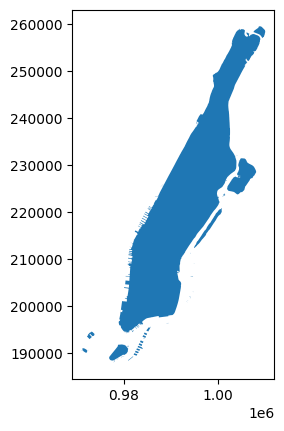

In [3]:
# Load the 'nybb' dataset using geodatasets
nybb_path = get_path("nybb")
nybb = gpd.read_file(nybb_path)

# Filter for Manhattan
manhattan = nybb[nybb["BoroName"] == "Manhattan"]

# Plot Manhattan
manhattan.plot()

# Display data
manhattan

# Create a Circular Boundary

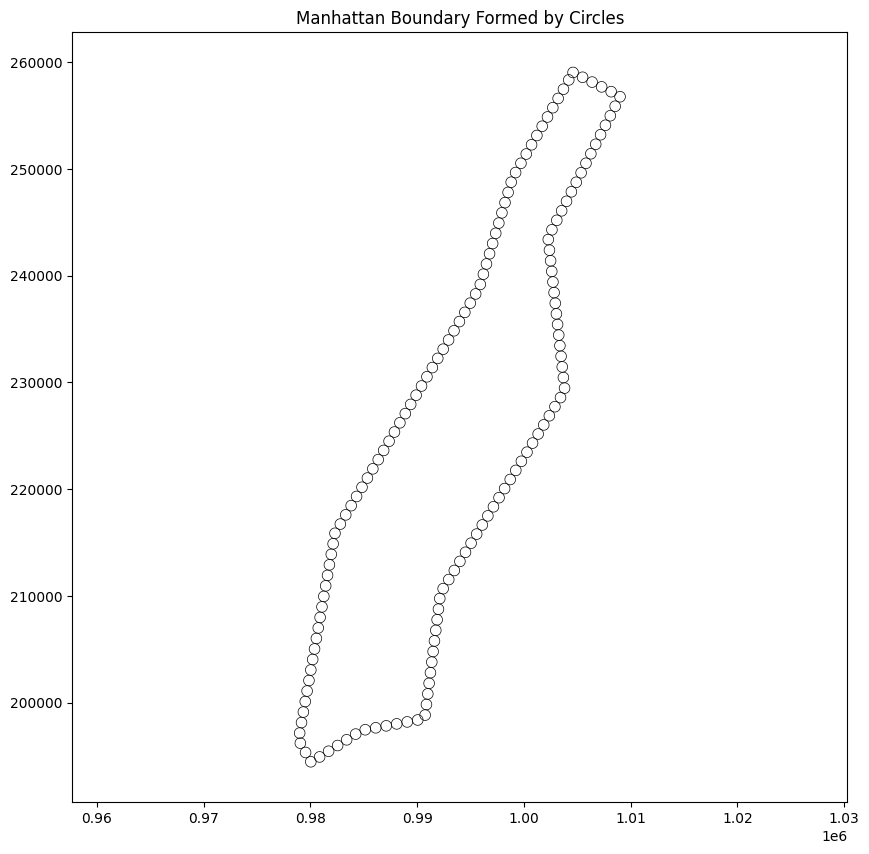

In [4]:
# Extract the largest polygon (mainland Manhattan)
mainland_geom = manhattan.geometry.iloc[0]
if mainland_geom.geom_type == "MultiPolygon":
    mainland_geom = max(mainland_geom.geoms, key=lambda polygon: polygon.area)

# Simplify the geometry to reduce vertex density
simplification_tolerance = 1000
simplified_geom = mainland_geom.simplify(simplification_tolerance, preserve_topology=True)

# Create a LineString for the simplified boundary
boundary_line = LineString(simplified_geom.exterior.coords)

# Dynamically calculate non-overlapping points
circle_radius = 500
circle_spacing = circle_radius * 2  # spacing between circle centers
current_distance = 0
non_overlapping_points = []

# Iterate along the simplified boundary to place circles
while current_distance <= boundary_line.length:
    point = boundary_line.interpolate(current_distance)
    non_overlapping_points.append(point)
    current_distance += circle_spacing

# Create larger circles (points) at these non-overlapping points
circles = [Point(point).buffer(circle_radius) for point in non_overlapping_points]

# Create a GeoDataFrame for the circles
circles_gdf = gpd.GeoDataFrame(geometry=circles, crs=manhattan.crs)

# Plot the circles
fig, ax = plt.subplots(figsize=(10, 10))
circles_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)
plt.title("Manhattan Boundary Formed by Circles")
plt.axis('equal')  # Ensure no stretching
plt.show()


# Final Visualization

In [5]:
# Load fonts using pyfonts
raleway_dots_url = "https://github.com/google/fonts/blob/main/ofl/ralewaydots/RalewayDots-Regular.ttf?raw=true"
lato_url = "https://github.com/google/fonts/blob/main/ofl/lato/Lato-Regular.ttf?raw=true"
raleway_dots_font = load_font(font_url=raleway_dots_url)
lato_font = load_font(font_url=lato_url)

## Export Map

<Axes: >

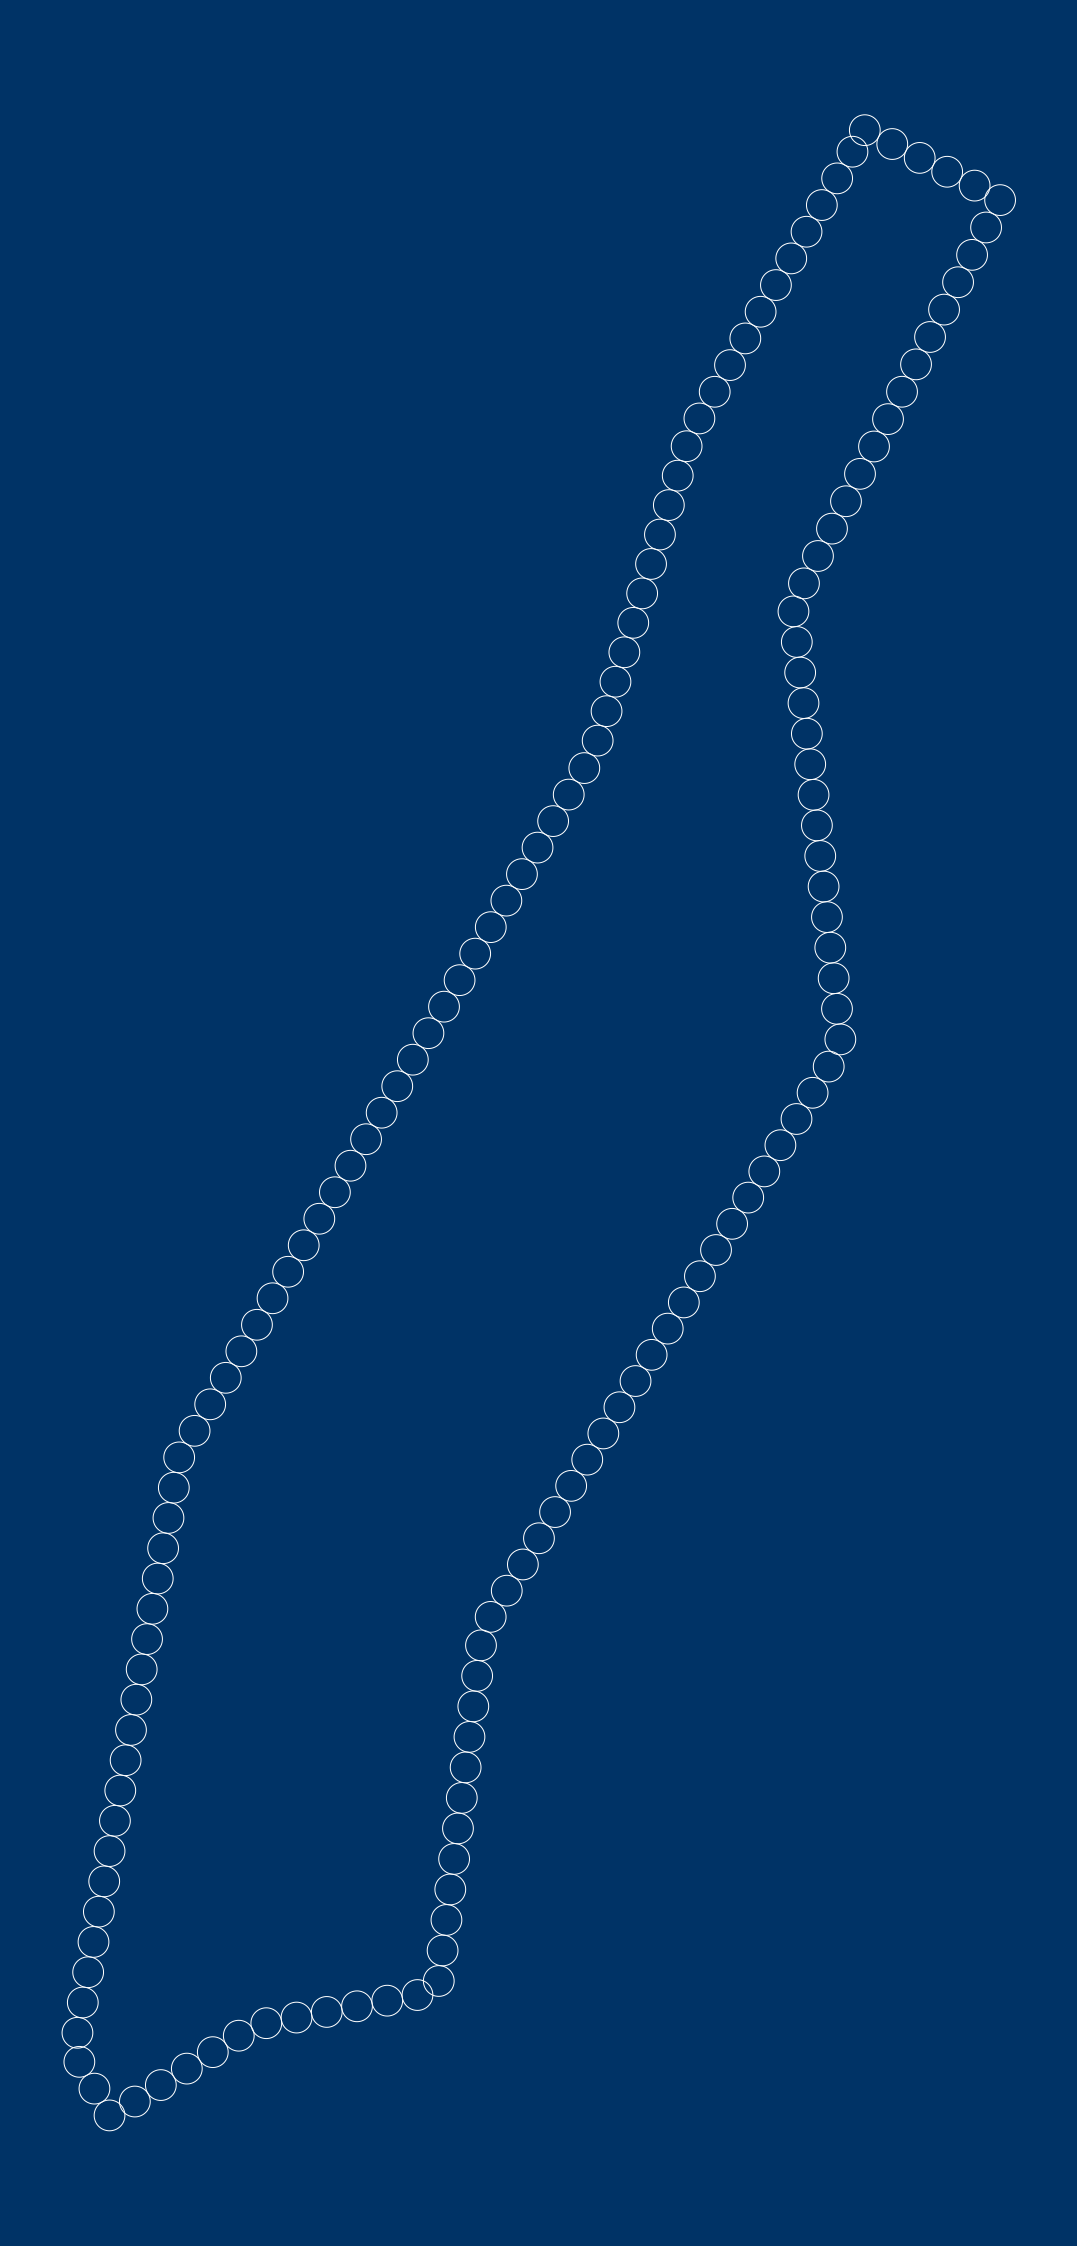

In [6]:
# Set dimensions in inches for HD (14 inches width, 20 inches height)
fig_width = 14
fig_height = 20
dpi = 144

# Plot the circles
fig, ax = plt.subplots(figsize=(fig_width, fig_height), facecolor="#003366", dpi=dpi)  # Set size and background color

# Plot the circles with no axes and styled borders
circles_gdf.plot(
    ax=ax,
    color='none',            # Hollow circles
    edgecolor='white',       # White border for circles
    linewidth=0.5
)

# Remove axes and other unnecessary elements
ax.set_axis_off()

# Save the plot as an image
plt.savefig("manhattan_circles_map.png", dpi=dpi, bbox_inches="tight", pad_inches=0)
# plt.close()

ax

## Annotation

In [7]:
# Download the fonts
title_font_url = "https://github.com/google/fonts/raw/main/ofl/codystar/Codystar-Regular.ttf"  # Codystar for title
footer_font_url = "https://github.com/google/fonts/raw/main/ofl/lato/Lato-Regular.ttf"  # Lato for footer
title_font_path = "TitleFont-Regular.ttf"
footer_font_path = "FooterFont-Regular.ttf"

# Download Title Font
with open(title_font_path, "wb") as file:
    file.write(requests.get(title_font_url).content)

# Download Footer Font
with open(footer_font_path, "wb") as file:
    file.write(requests.get(footer_font_url).content)


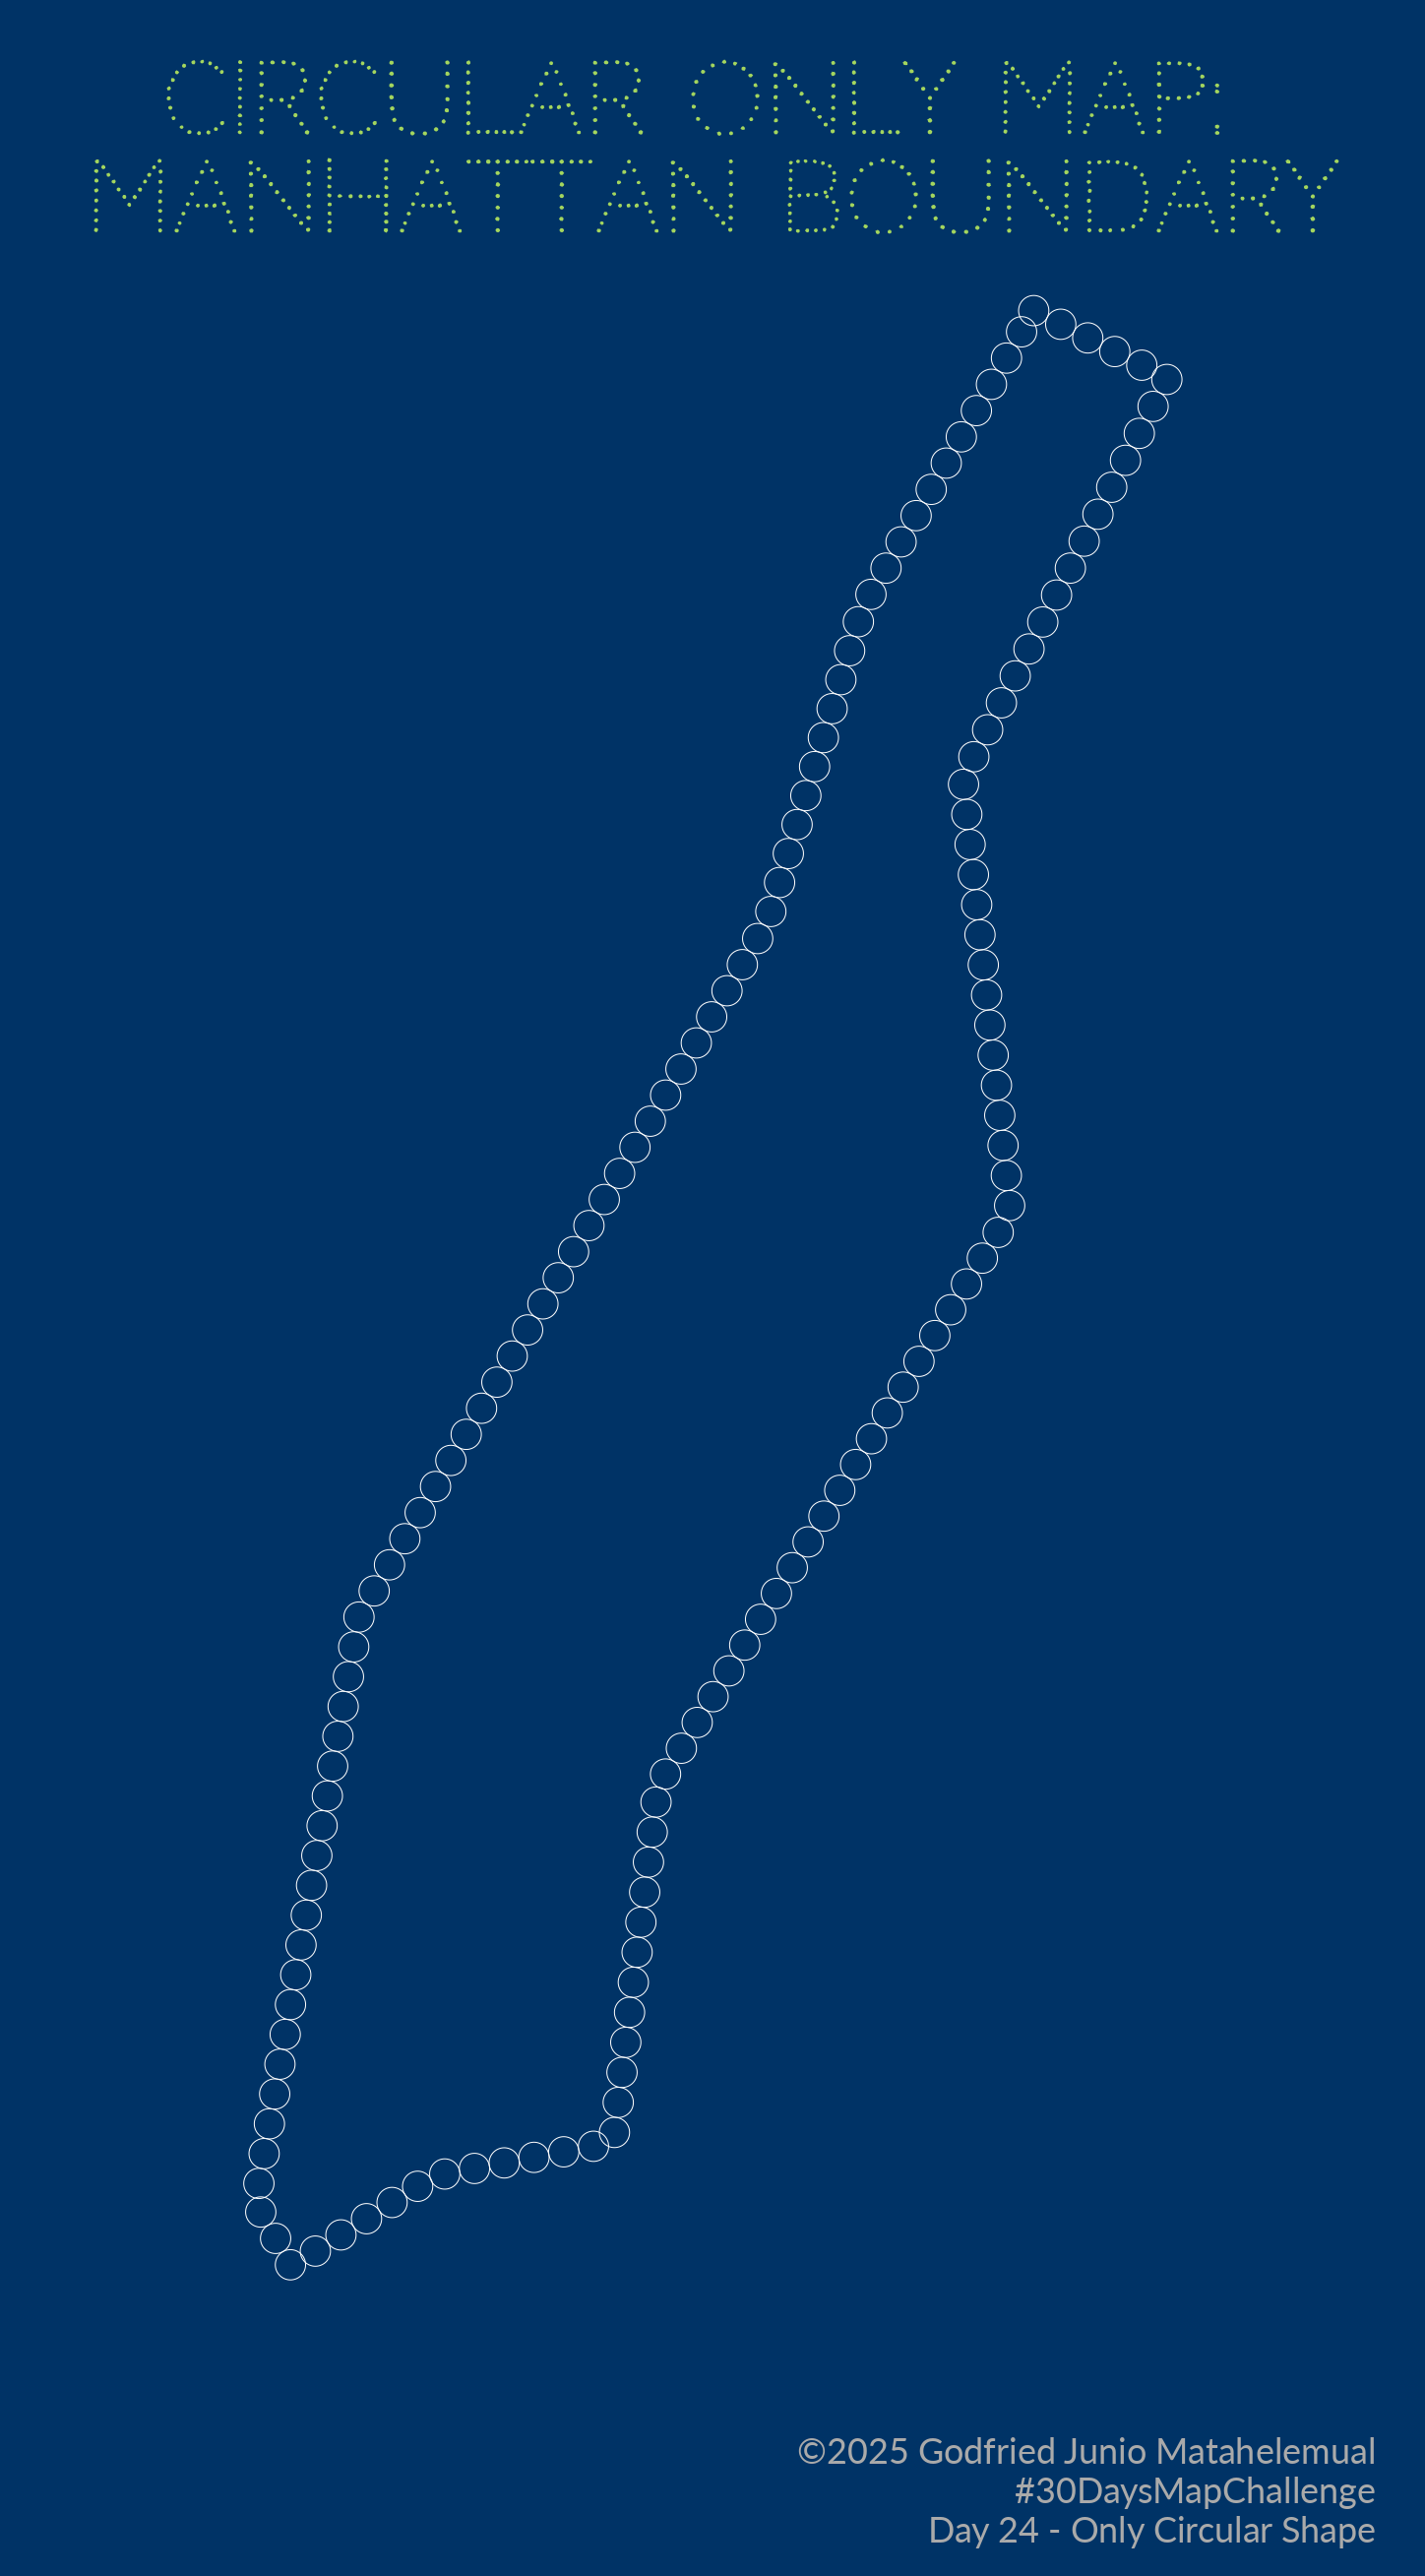

In [9]:
# Load the exported map image
map_image = Image.open("manhattan_circles_map.png")

# Add padding
padding = (200, 200, 200, 200)  # (left, top, right, bottom)
padded_image = ImageOps.expand(map_image, border=padding, fill="#003366")

# Create a drawing context
draw = ImageDraw.Draw(padded_image)

# Load fonts
title_font = ImageFont.truetype(title_font_path, size=100)
footer_font = ImageFont.truetype(footer_font_path, size=36)

# Add the title
title_text = "CIRCULAR ONLY MAP: \nMANHATTAN BOUNDARY"
title_position = (padded_image.width // 2, 150)  # Centered in the top padding
draw.multiline_text(
    title_position,
    title_text,
    font=title_font,
    fill="#A4D65E",
    anchor="mm",  # Middle-center alignment
    align="center",
)

# Add the footer
footer_text = "©2025 Godfried Junio Matahelemual\n#30DaysMapChallenge\nDay 24 - Only Circular Shape"
footer_position = (padded_image.width - 50, padded_image.height - 150)  # Bottom-right in the padding
draw.multiline_text(
    footer_position,
    footer_text,
    font=footer_font,
    fill="#AAAAAA",
    anchor="ra",  # Right-aligned
    align="right",
)

# Save the final annotated image
padded_image.save("day24_CircularShapes_ManhattanBoundary.png")

# Show the final image
padded_image
